# Install libs

In [1]:
%%capture
# # Transformers installation
! pip install transformers
! pip install datasets
# # To install from source instead of the last release, comment the command above and uncomment the following one.
# # ! pip install git+https://github.com/huggingface/transformers.git

# Import libs

In [ ]:
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch
import torch.nn.functional as F
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput 



# Getting the Data and Preview it
Below we are going to load the data and show you how to create the splits. However, we don't need to split the data manually becuase I have already created the splits and stored those files seperately which you can quickly download below:

https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp/code


In [5]:
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

--2021-06-15 06:30:28--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2021-06-15 06:30:29--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7a23159733e799a245f0402843.dl.dropboxusercontent.com/cd/0/inline/BQeA4vype346En4UNkNGzzAj1WESpRDVVltJ-fBPAVK6NMP7xNMtMW5_Kbi8d6rzo6hNyeCYDFtZb9_DPI2JSwnf3A6EucelhRkStgMC5jLkdu04YVFlal1XsdwnPwT3jukolytSzUm8DNd8pmMc3DQx/file# [following]
--2021-06-15 06:30:29--  https://uc7a23159733e799a245f0402843.dl.dropboxusercontent.com/cd/0/inline/BQeA4vype346En4UNkNGzzAj1WESpRDVVltJ-fBPAVK6NMP7xNMtMW5_Kbi8d6rzo6hNy

In [10]:
## helper function
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

(416809, 2)


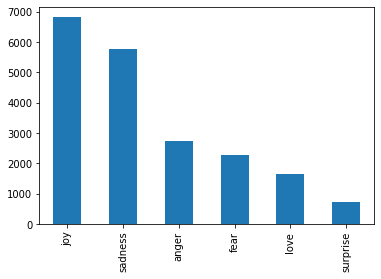

In [11]:
data = load_from_pickle(directory="merged_training.pkl")

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

data = data[data["emotions"].isin(label2int.keys())]

print(data.shape)

data = data.sample(n=20000);

data.emotions.value_counts().plot.bar()

Data has been preprocessed already, using technique from this paper: https://www.aclweb.org/anthology/D18-1404/
"a graph-based feature extraction
mechanism to extract emotion-relevant representations in an unsupervised manner"

In [12]:
data.head()

,text,emotions
31622,i never write fanfiction primarily because i f...,fear
18382,i feel i wronged you,anger
15672,i feel that he is going to be faithful to give...,love
8814,i am sorry you are feeling rejected,sadness
93158,i know that i am already feeling thrilled abou...,joy


In [13]:
## reset index
data.reset_index(drop=True, inplace=True)

In [14]:
## check unique emotions in the dataset
data.emotions.unique()

array(['fear', 'anger', 'love', 'sadness', 'joy', 'surprise'],
      dtype=object)

## Split the data and store into individual text files

In [15]:
# dummies = pd.get_dummies(data.emotions)
# ohe_mapping = {i: c for i, c in enumerate(dummies.columns)}

In [16]:
# Creating training and validation sets using an 80-20 split
input_train, input_val, train_labels, val_labels = train_test_split(data.text.to_list(), 
                                                                    # dummies.values,
                                                                    data.emotions.map(label2int).to_numpy(), 
                                                                    # data.emotions.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, val_labels, test_labels = train_test_split(input_val, val_labels, test_size=0.5)


## create a dataframe for each dataset
# train_dataset = pd.DataFrame(data={"text": input_train, "class": train_labels})
# val_dataset = pd.DataFrame(data={"text": input_val, "class": val_labels})
# test_dataset = pd.DataFrame(data={"text": input_test, "class": test_labels})
# final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

# train_dataset.to_csv(train_path, sep=";",header=False, index=False)
# val_dataset.to_csv(test_path, sep=";",header=False, index=False)
# test_dataset.to_csv(val_path, sep=";",header=False, index=False)

## Preparing the datasets

In [17]:
# Define the model
model_name = "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [18]:
train_encodings = tokenizer(input_train, truncation=True, padding=True)
val_encodings = tokenizer(input_val, truncation=True, padding=True)
test_encodings = tokenizer(input_test, truncation=True, padding=True)

In [19]:
class EmoDataset(torch.utils.data.Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
train_dataset = EmoDataset(train_encodings, train_labels)
val_dataset = EmoDataset(val_encodings, val_labels)
test_dataset = EmoDataset(test_encodings, test_labels)

# Building Custom Classification head on top of LM base model

Use Mish activiation function as in the one proposed in the original tutorial

In [21]:
# Use Mish activiation function as in the one proposed in the original tutorial
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, 
                 base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        self.n_classes = n_classes
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(in_features=base_model_output_size, 
                      out_features=n_classes),
            nn.Softmax(dim=-1) 
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, inputs, *args):
        input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
        hidden_states = self.base_model(input_ids=input_ids, 
                                        attention_mask=attention_mask)
        # maybe do some pooling / RNNs... go crazy here!
        
        # use the <s> representation
        # return self.classifier(hidden_states[0][:, 0, :])

        # creates a vector of [batch_size, base_model_output_size]
        clf_input = hidden_states['last_hidden_state'][:, 0, :]
        return SequenceClassifierOutput(logits=self.classifier(clf_input))

In [22]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(device)

# del tokenizer
# # del model
# # del trainer
# torch.cuda.empty_cache()

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           num_labels=len(label2int))

emotion_model = EmoModel(base_model=model.base_model, 
                         n_classes=len(label2int)) 

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

This issues a warning about some of the pretrained weights not being used and some weights being randomly
initialized. That's because we are throwing away the pretraining head of the BERT model to replace it with a
classification head which is randomly initialized. We will fine-tune this model on our task, transferring the knowledge
of the pretrained model to it (which is why doing this is called transfer learning).

## Examples of output

In [25]:
output = emotion_model(val_dataset.__getitem__(slice(5)))
output

SequenceClassifierOutput([('logits',
                           tensor([[0.1481, 0.1688, 0.1729, 0.1684, 0.1551, 0.1867],
                                   [0.1483, 0.1765, 0.1661, 0.1700, 0.1558, 0.1833],
                                   [0.1574, 0.1793, 0.1627, 0.1649, 0.1575, 0.1781],
                                   [0.1573, 0.1704, 0.1645, 0.1722, 0.1573, 0.1783],
                                   [0.1439, 0.1755, 0.1643, 0.1695, 0.1589, 0.1879]],
                                  grad_fn=<SoftmaxBackward>))])

In [26]:
type(output)

transformers.modeling_outputs.SequenceClassifierOutput

In [27]:
val_dataset.__getitem__(slice(5))['labels']

tensor([1, 0, 4, 0, 1])

In [28]:
loss_fct = torch.nn.NLLLoss()
loss_fct(torch.log(output.logits), val_dataset.__getitem__(slice(5))['labels'])

tensor(1.8251, grad_fn=<NllLossBackward>)

In [29]:
len(val_dataset.__getitem__(slice(5))['input_ids'])

5

In [30]:
ds = val_dataset.__getitem__(slice(3))
ds.pop('labels')
list(ds.values())
base_output = model.base_model(*list(ds.values()))
base_output

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[ 1.2605e-02,  1.1973e-01,  6.5141e-03,  ..., -1.4340e-01,
                                                         -3.5317e-02,  3.0978e-02],
                                                        [ 4.6048e-02, -2.5601e-01, -6.6653e-02,  ..., -1.5768e-01,
                                                         -5.8281e-02, -4.1879e-02],
                                                        [ 9.6109e-02,  1.8662e-02,  1.5499e-01,  ..., -4.0825e-01,
                                                          8.2499e-02, -2.1210e-01],
                                                        ...,
                                                        [ 1.0349e-01, -6.5940e-02,  6.6869e-02,  ..., -5.8757e-02,
                                                         -2.2134e-02, -5.8657e-02],
                                                        [ 1.0349e-01, -6.59

In [31]:
base_output[0].shape

torch.Size([3, 66, 768])

In [32]:
base_output['last_hidden_state'][:, 0, :].shape

torch.Size([3, 768])

In [33]:
seq_clf_output = model(*list(ds.values()))
type(seq_clf_output)

transformers.modeling_outputs.SequenceClassifierOutput

In [34]:
seq_clf_output

SequenceClassifierOutput([('logits',
                           tensor([[ 0.1519,  0.3092,  0.2868, -0.0728, -0.0139,  0.0485],
                                   [ 0.1515,  0.3318,  0.2948, -0.1005, -0.0049,  0.0532],
                                   [ 0.1550,  0.3369,  0.2923, -0.0787,  0.0025,  0.0377]],
                                  grad_fn=<AddmmBackward>))])

# Fine-tuning in PyTorch with the Trainer API

Since PyTorch does not provide a training loop, the 🤗 Transformers library provides a `Trainer`
API that is optimized for 🤗 Transformers models, with a wide range of training options and with built-in features like
logging, gradient accumulation, and mixed precision.

In [ ]:
# from transformers import TrainerCallback

# class PrinterCallback(TrainerCallback):

#     def on_log(self, args, state, control, logs=None, **kwargs):
#         _ = logs.pop("total_flos", None)
#         if state.is_local_process_zero:
#             print(logs)

To have the `Trainer` compute and report metrics, we need to give it a `compute_metrics`
function that takes predictions and labels (grouped in a namedtuple called `EvalPrediction`) and
return a dictionary with string items (the metric names) and float values (the metric values).

The 🤗 Datasets library provides an easy way to get the common metrics used in NLP with the `load_metric` function.
here we simply use accuracy. Then we define the `compute_metrics` function that just convert logits to predictions
(remember that all 🤗 Transformers models return the logits) and feed them to `compute` method of this metric.

The compute function needs to receive a tuple (with logits and labels) and has to return a dictionary with string keys
(the name of the metric) and float values. It will be called at the end of each evaluation phase on the whole arrays of
predictions/labels.

In [35]:
from datasets import load_metric
from sklearn.metrics import roc_auc_score

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics_dict = dict()
    metrics_dict.update(metric.compute(predictions=predictions, references=labels))
    # Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).
    metrics_dict.update({'roc_auc': roc_auc_score(labels, logits, 
                                                  average='weighted', 
                                                  multi_class='ovr')})
    return metrics_dict

Then, to define our `Trainer`, we will need to instantiate a
`TrainingArguments`. This class contains all the hyperparameters we can tune for the
`Trainer` or the flags to activate the different training options it supports.

In [36]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    evaluation_strategy="epoch"
)

# class MultilabelTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.logits
#         loss_fct = torch.nn.BCEWithLogitsLoss()
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels),
#                         labels.float().view(-1, self.model.config.num_labels))
#         return (loss, outputs) if return_outputs else loss

class MultiClassTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(inputs)
        logits = outputs.logits
        loss_fct = torch.nn.NLLLoss()
        # loss = loss_fct(outputs.view(-1, self.model.n_classes),
        #                 labels.float().view(-1, self.model.n_classes))
        loss = loss_fct(torch.log(logits), labels)
        return (loss, outputs) if return_outputs else loss

trainer = MultiClassTrainer(
    # model=model,                       # the instantiated 🤗 Transformers model to be trained
    model=emotion_model,
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,
)

In [37]:
trainer_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc
1,0.551900,0.369576,0.878000,0.983141
2,0.239400,0.196189,0.919000,0.995477
3,0.119200,0.145117,0.922500,0.996877


In [41]:
trainer.evaluate()

{'epoch': 3.0,
 'eval_accuracy': 0.9225,
 'eval_loss': 0.14511696994304657,
 'eval_mem_cpu_alloc_delta': 65536,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 143976960,
 'eval_roc_auc': 0.9968769453697296,
 'eval_runtime': 3.4384,
 'eval_samples_per_second': 581.668}

In [42]:
# For loading the data from file

# from torch.utils.data import DataLoader, Dataset
# class EmoDataset(Dataset):
#     def __init__(self, path):
#         super().__init__()
#         self.data_column = "text"
#         self.class_column = "class"
#         self.data = pd.read_csv(path, sep=";", header=None, 
#                                 names=[self.data_column, self.class_column],
#                                 engine="python")
#         print(path)
#         display(self.data.head(2))

#     def __getitem__(self, idx):
#         return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

#     def __len__(self):
#         return self.data.shape[0]

# import torch

# class TokenizersCollateFn:
#     def __init__(self, tokenizer):
#         self.tokenizer = tokenizer

#     def __call__(self, batch):
#         # encoded = self.tokenizer.encode_batch([x[0] for x in batch])
#         encoded = self.tokenizer([x[0] for x in batch], 
#                    max_length=150, padding=True, truncation=True, 
#                    return_tensors="pt")
        
#         sequences_padded = torch.tensor([enc.ids for enc in encoded])
#         attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
#         labels = torch.tensor([x[1] for x in batch])
        
#         return (sequences_padded, attention_masks_padded), labels
#         # return inputs, labels

# Evaluation on my data

Now to check the results, we need to write the evaluation loop. Here we accumulate the predictions at each batch before computing the final
result when the loop is finished.

In [ ]:
metric= load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()